In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [3]:

# 1. GCS 인증 및 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"
base_path = "gs://final_project_enuyu/data/final_project/votes/"

# 2. 필요한 테이블만 선택
target_tables = {
    "userrecord": "accounts_userquestionrecord",
    "question": "polls_question",
    "piece": "polls_questionpiece",
    "qset": "polls_questionset",
    "point": "accounts_pointhistory"
}

# 3. 테이블 로딩
tables = {}
for key, name in target_tables.items():
    print(f"Loading: {name}")
    tables[key] = pd.read_parquet(f"{base_path}{name}.parquet", engine="pyarrow")

# 4. 기준 테이블
df = tables["userrecord"].copy()

# 5. 자료형 통일 (str)
df["question_piece_id"] = df["question_piece_id"].astype(str)
tables["piece"]["id"] = tables["piece"]["id"].astype(str)
tables["qset"] = tables["qset"].explode("question_piece_id_list")
tables["qset"]["question_piece_id_list"] = tables["qset"]["question_piece_id_list"].astype(str)

# 6. 병합 시작

# 질문 내용
df = df.merge(tables["question"][["id", "question_text"]],
              left_on="question_id", right_on="id", how="left")
df.drop(columns=["id"], inplace=True, errors="ignore")

# 투표 여부
df = df.merge(tables["piece"][["id", "is_voted", "is_skipped"]],
              left_on="question_piece_id", right_on="id", how="left")
df.drop(columns=["id"], inplace=True, errors="ignore")

# 질문 세트 정보
df = df.merge(tables["qset"][["question_piece_id_list", "opening_time", "status"]],
              left_on="question_piece_id", right_on="question_piece_id_list", how="left")
df.rename(columns={"status": "status_set"}, inplace=True)
df.drop(columns=["question_piece_id_list"], inplace=True, errors="ignore")

# 병합 키 자동 탐색
if "user_question_record_id" in df.columns:
    merge_key = "user_question_record_id"
elif "id" in df.columns:
    merge_key = "id"
elif "id_x" in df.columns:
    merge_key = "id_x"
else:
    raise KeyError("병합을 위한 고유 ID 컬럼(id, id_x, user_question_record_id)이 없음")

# 포인트 지급 병합
df = df.merge(
    tables["point"][["user_question_record_id", "delta_point"]],
    left_on=merge_key, right_on="user_question_record_id", how="left"
)
df.drop(columns=["user_question_record_id"], inplace=True, errors="ignore")

# 7. 최종 컬럼 선택
final_cols = [
    "user_id", "chosen_user_id", "question_id", "question_piece_id",
    "status", "answer_status", "has_read", "created_at",
    "question_text", "is_voted", "is_skipped",
    "opening_time", "status_set", "delta_point"
]
df = df[[col for col in final_cols if col in df.columns]]

# 8. 결과 확인
print("병합 완료! DataFrame shape:", df.shape)
display(df.head())


Loading: accounts_userquestionrecord
Loading: polls_question
Loading: polls_questionpiece
Loading: polls_questionset
Loading: accounts_pointhistory
병합 완료! DataFrame shape: (2335930, 12)


,user_id,chosen_user_id,question_id,question_piece_id,answer_status,has_read,created_at,question_text,is_voted,is_skipped,opening_time,delta_point
0,849436,849469,252,998458,N,0,2023-04-28 12:27:49,손이 가장 이쁘게 생겼을거 같은 사람은?,1,0,NaT,9.0
1,849436,849446,244,998459,N,0,2023-04-28 12:28:02,대학교에서 학생회장할 것 같은 사람은?,1,0,NaT,9.0
2,849436,849454,183,998460,N,1,2023-04-28 12:28:09,나의 자존감을 가장 많이 높여줬던 사람은?,1,0,NaT,5.0
3,849436,847375,101,998461,N,0,2023-04-28 12:28:16,미래의 틱톡커는?,1,0,NaT,13.0
4,849436,849477,209,998462,N,1,2023-04-28 12:28:26,항상 좋은 냄새가 나는 사람은?,1,0,NaT,5.0


#### 질문별 투표율 상위 5개 (5~7월)

In [4]:
# 1. 날짜 필터링 (5~7월)
df['created_at'] = pd.to_datetime(df['created_at'])
df_5to7 = df[(df['created_at'].dt.month >= 5) & (df['created_at'].dt.month <= 7)]

# 2. 질문별 투표 수 계산
vote_counts = df_5to7.groupby("question_text")["is_voted"].count().reset_index()
vote_counts.rename(columns={"is_voted": "vote_count"}, inplace=True)

# 3. 투표 수 기준 상위 5개 정렬
top5_votes = vote_counts.sort_values("vote_count", ascending=False).head(5)

# 4. 출력
display(top5_votes)


,question_text,vote_count
87,vote,18542
1255,라면 잘 끓일 것 같은 사람은?,4072
26,2세가 가장 귀여울 것 같은 사람은?,3823
500,같이 캠핑가고 싶은 사람은?,3740
129,가장 깔끔할 것 같은 친구는?,3732


#### 질문별 투표 수 하위 5개

In [5]:
# 2. 질문별 투표 수 계산
vote_counts = df_5to7.groupby("question_text")["is_voted"].count().reset_index()
vote_counts.rename(columns={"is_voted": "vote_count"}, inplace=True)

# 3. 투표 수 기준 하위 5개 정렬
bottom5_votes = vote_counts.sort_values("vote_count", ascending=True).head(5)

# 4. 출력
display(bottom5_votes)

,question_text,vote_count
1857,사달라는거 다 사줄 것 같은 사람은?,1
522,개학 하자마자 인사 될것 같은 사람,2
764,나도 모르게 자꾸 시선이 가는사람,3
3733,한번쯤 목마를 태워주고 싶은사람은?,3
1333,만약에 영혼이 바뀐다면 누가 되고싶어?,4


#### delta_point별 분포 시각화

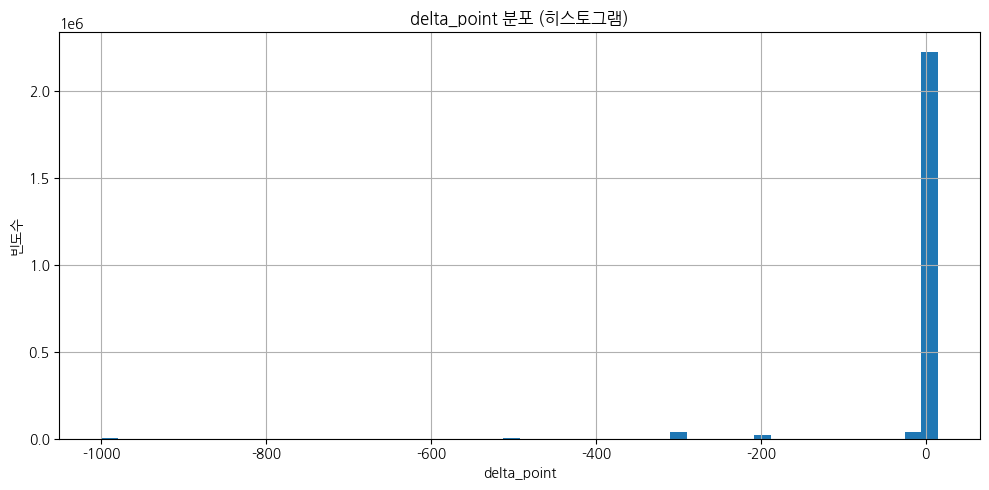

In [6]:
plt.figure(figsize=(10, 5))
df["delta_point"].dropna().hist(bins=50)
plt.title("delta_point 분포 (히스토그램)")
plt.xlabel("delta_point")
plt.ylabel("빈도수")
plt.grid(True)
plt.tight_layout()
plt.show()

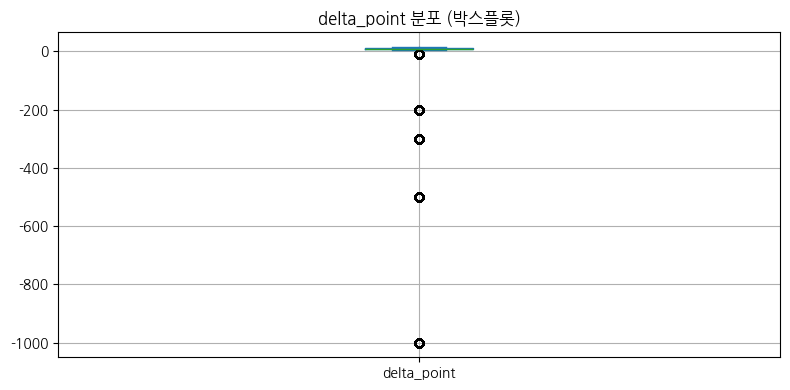

In [7]:
plt.figure(figsize=(8, 4))
df["delta_point"].dropna().plot.box()
plt.title("delta_point 분포 (박스플롯)")
plt.grid(True)
plt.tight_layout()
plt.show()

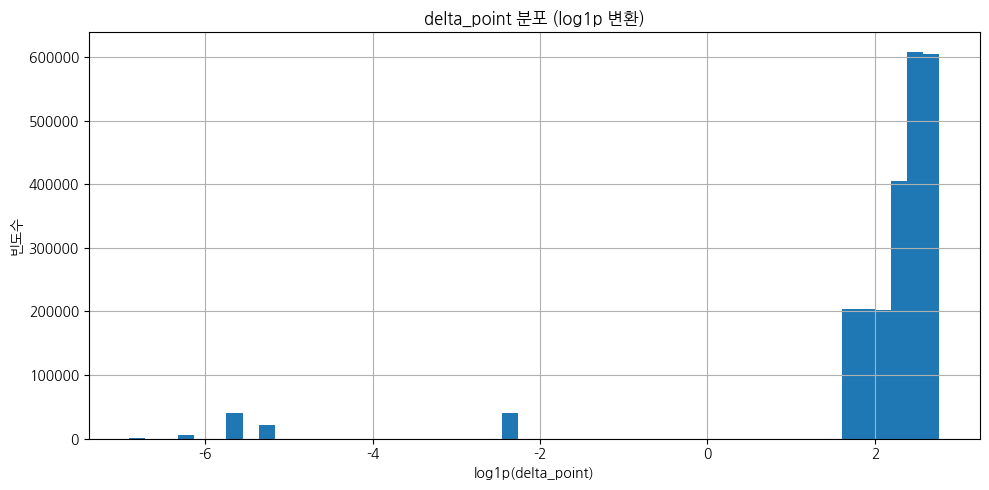

In [8]:
plt.figure(figsize=(10, 5))
df["delta_point"].dropna().apply(lambda x: np.log1p(abs(x)) * np.sign(x)).hist(bins=50)
plt.title("delta_point 분포 (log1p 변환)")
plt.xlabel("log1p(delta_point)")
plt.ylabel("빈도수")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 포인트 증가 vs 감소 비교

In [9]:
df["delta_sign"] = df["delta_point"].apply(lambda x: "Gain" if x > 0 else ("Loss" if x < 0 else "Zero"))
df["delta_sign"].value_counts()


delta_sign
Gain    2227344
Loss     108582
Zero          4
Name: count, dtype: int64

- Gain (포인트 증가): 2,227,344 / 약 95.3%
- Loss (포인트 감소): 108,582 / 약 4.6%
- Zero (변화 없음): 4 / ≈ 0%

- 압도적으로 많은 투표가 보상 중심(Gain) → 시스템이 인센티브 구조로 설계되었음
- Loss는 전체의 약 5%인데, 이 유저들의 리텐션이 낮다면 “벌점 → 이탈” 가능성이 있음

#### 투표 여부와의 관계

In [10]:
df.groupby("is_voted")["delta_point"].describe()

,count,mean,std,min,25%,50%,75%,max
is_voted,,,,,,,,
1,2335926.0,0.481404,57.271975,-1000.0,7.0,10.0,13.0,15.0


1. 투표는 보상을 주는 행동이다.
- 중앙값이 +10포인트이고, 75%가 +13 이상을 받았음 → 대부분 투표에 대해 보상이 주어짐.
2. 일부 유저는 강한 벌점을 받았다.
- 최소값이 -1000 → 아주 예외적으로 투표가 문제를 일으켜 벌점을 받은 경우.
3. 평균은 왜곡되어 있다.
- 평균은 +0.48점으로 낮지만, 이는 일부 극단적 음수 때문이며 대부분의 유저는 이득을 본다.

#### 상위 포인트 사용자 Top 10

In [11]:
df.groupby("user_id")["delta_point"].sum().sort_values(ascending=False).head(10)

user_id
849103     31087.0
952220     28744.0
1214232    17802.0
1417129    17552.0
1225963    17491.0
1378689    17146.0
1170559    17076.0
1152932    16740.0
1428542    16476.0
943631     15427.0
Name: delta_point, dtype: float64

1. 상위 유저는 1만~3만 포인트를 보유          
→ 일반적인 보상이 10점 기준일 때, 수천 번 이상의 활동을 의미                    
→ 즉, 매우 적극적이며 충성도 높은 유저                
2. Top 1 유저는 최소 3천 회 이상 긍정적 행동             
→ 단순히 활동만이 아니라 정책에 부합하는 양질의 행동일 가능성              
3. 이들 유저의 특성 분석 필요                         
→ 언제 활동했는지, 어떤 질문에 많이 참여했는지, 리텐션은 긴지?                 



In [12]:
top_users = [849103, 952220, 1214232, 1417129, 1225963, 1378689, 1170559, 1152932, 1428542, 943631]
retention_df[retention_df["user_id"].isin(top_users)][["user_id", "retention_days", "total_points"]]


NameError: name 'retention_df' is not defined

1. 포인트 상위권은 대체로 리텐션도 길다
- 상위 2명은 2개월 이상 꾸준히 활동한 충성 유저
2. 일부 유저는 짧은 시간에 포인트를 집중적으로 획득
- 1152932, 1417129 등은 16~19일 만에 1.6만점 이상 획득 → 매우 집중된 활동
3. 상위 유저들은 모두 이탈하지 않았다                
→ retention_days > 15 모두 활동 지속 기록 있음 → 보상이 이탈 방지에 효과


####  포인트 변화량과 리텐션(생존일) 간의 관계

In [13]:
# created_at datetime화
df["created_at"] = pd.to_datetime(df["created_at"])

# 유저별 활동 시작일과 마지막 활동일
retention_df = df.groupby("user_id").agg(
    first_seen=("created_at", "min"),
    last_seen=("created_at", "max"),
    active_days=("created_at", lambda x: x.dt.date.nunique()),
    total_points=("delta_point", "sum"),
    total_votes=("is_voted", "sum")
).reset_index()

# 생존일수 계산
retention_df["retention_days"] = (retention_df["last_seen"] - retention_df["first_seen"]).dt.days


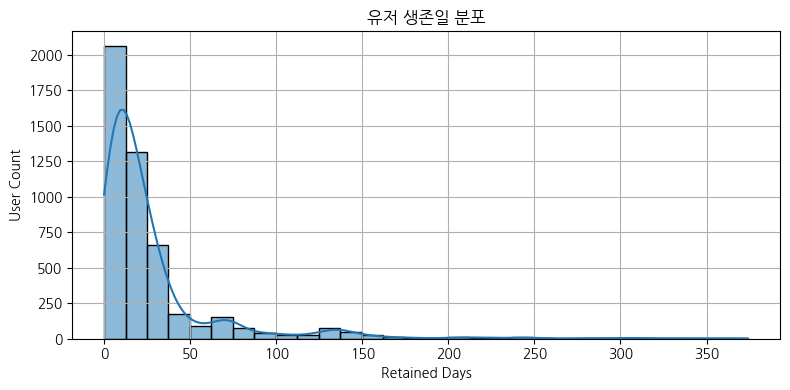

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 생존일 기준 히스토그램
plt.figure(figsize=(8, 4))
sns.histplot(retention_df["retention_days"], bins=30, kde=True)
plt.title("유저 생존일 분포")
plt.xlabel("Retained Days")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()


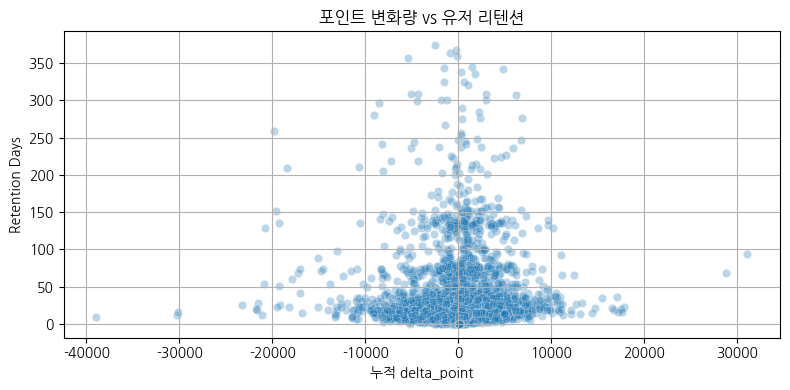

In [16]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=retention_df, x="total_points", y="retention_days", alpha=0.3)
plt.title("포인트 변화량 vs 유저 리텐션")
plt.xlabel("누적 delta_point")
plt.ylabel("Retention Days")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
def point_group(p):
    if p > 50: return "High Gain"
    elif p < -10: return "High Loss"
    else: return "Neutral"

retention_df["point_group"] = retention_df["total_points"].apply(point_group)

# 평균 생존일 비교
retention_df.groupby("point_group")["retention_days"].mean()


point_group
High Gain    26.921838
High Loss    30.205978
Neutral       8.282609
Name: retention_days, dtype: float64

- High Loss 그룹이 가장 오래 생존했다는 점에서,
   - 벌점만으로 이탈을 유도하지는 못하고 있음
   - 일부 유저는 자극적인 행동을 지속하며 유지되고 있음

In [18]:
# 유저별 첫 활동일 & 마지막 활동일
user_lifespan = df.groupby('user_id')['created_at'].agg(['min', 'max']).reset_index()
user_lifespan['retention_days'] = (user_lifespan['max'] - user_lifespan['min']).dt.days

In [19]:
first_point = df[df['delta_point'].notna()].sort_values('created_at').groupby('user_id').first().reset_index()
merged = pd.merge(first_point[['user_id', 'delta_point']], user_lifespan, on='user_id', how='left')

# 기준 설정 (예: retention_days ≥ 7)
merged['is_retained'] = merged['retention_days'] >= 7

# 포인트 크기별 잔존율 확인
merged['point_group'] = pd.cut(merged['delta_point'], [-float('inf'), 0, 5, 20, float('inf')], labels=['Loss', 'Low', 'Mid', 'High'])
retention_by_point = merged.groupby('point_group')['is_retained'].mean().reset_index()


/tmp/ipykernel_1831049/2463203878.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_point = merged.groupby('point_group')['is_retained'].mean().reset_index()


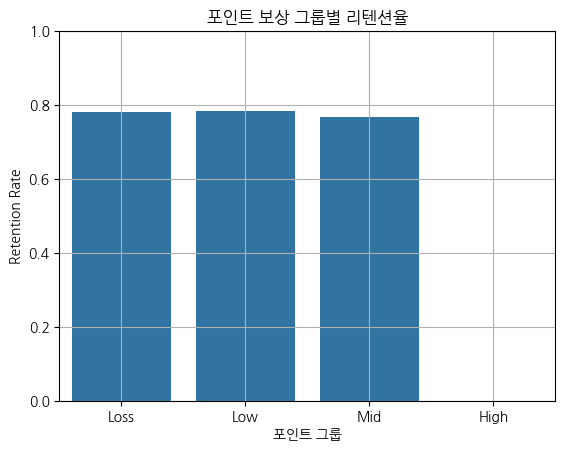

In [20]:

sns.barplot(data=retention_by_point, x='point_group', y='is_retained')
plt.title("포인트 보상 그룹별 리텐션율")
plt.ylabel("Retention Rate")
plt.xlabel("포인트 그룹")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


/tmp/ipykernel_1831049/3769726234.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  '포인트 그룹': first_action.groupby('delta_group')['is_retained'].mean(),
/tmp/ipykernel_1831049/3769726234.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df], ignore_index=True)


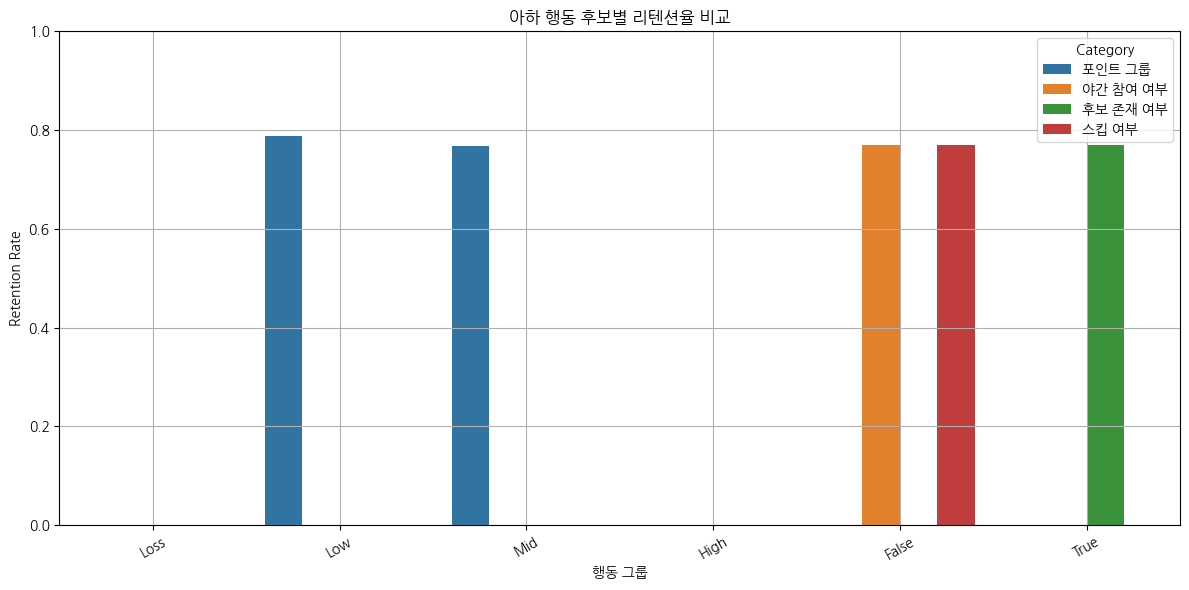

In [21]:


# 1. 유저별 생존일 계산
user_lifespan = df.groupby('user_id')['created_at'].agg(['min', 'max']).reset_index()
user_lifespan['retention_days'] = (user_lifespan['max'] - user_lifespan['min']).dt.days

# 2. retention 여부 정의 (예: 7일 이상 활동한 유저)
user_lifespan['is_retained'] = user_lifespan['retention_days'] >= 7

# 3. 유저별 첫 행동 가져오기
df_sorted = df.sort_values(['user_id', 'created_at'])
first_action = df_sorted.groupby('user_id').first().reset_index()

# 4. 첫 행동과 리텐션 데이터 병합
first_action = first_action.merge(user_lifespan[['user_id', 'retention_days', 'is_retained']], on='user_id', how='left')

# 5. 아하 행동 후보별 그룹 생성
first_action['delta_group'] = pd.cut(
    first_action['delta_point'].fillna(0),
    bins=[-float('inf'), 0, 5, 20, float('inf')],
    labels=['Loss', 'Low', 'Mid', 'High']
)

first_action['night_participation'] = first_action['opening_time'].dt.hour >= 21
first_action['has_candidate'] = first_action['chosen_user_id'].notna()
first_action['skipped'] = first_action['is_skipped'] == 1

# 6. 리텐션율 계산
grouped_retention = {
    '포인트 그룹': first_action.groupby('delta_group')['is_retained'].mean(),
    '야간 참여 여부': first_action.groupby('night_participation')['is_retained'].mean(),
    '후보 존재 여부': first_action.groupby('has_candidate')['is_retained'].mean(),
    '스킵 여부': first_action.groupby('skipped')['is_retained'].mean()
}

# 시각화용 변환
results = pd.DataFrame({
    'Group': [],
    'Category': [],
    'Retention Rate': []
})

for category, series in grouped_retention.items():
    temp_df = series.reset_index()
    temp_df.columns = ['Group', 'Retention Rate']
    temp_df['Category'] = category
    results = pd.concat([results, temp_df], ignore_index=True)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x='Group', y='Retention Rate', hue='Category')
plt.ylim(0, 1)
plt.title("아하 행동 후보별 리텐션율 비교")
plt.ylabel("Retention Rate")
plt.xlabel("행동 그룹")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [22]:
df['created_at'] = pd.to_datetime(df['created_at'])
vote_5to7 = df[(df['created_at'] >= '2023-05-01') & (df['created_at'] <= '2023-07-31')]


#### 투표율 (is_voted 기준 비율)

In [24]:
total = vote_5to7.shape[0]
voted = vote_5to7['is_voted'].sum()
vote_rate = voted / total

print(f"전체 투표율: {vote_rate:.2%} ({voted:,} / {total:,})")

전체 투표율: 100.00% (2,293,779 / 2,293,779)


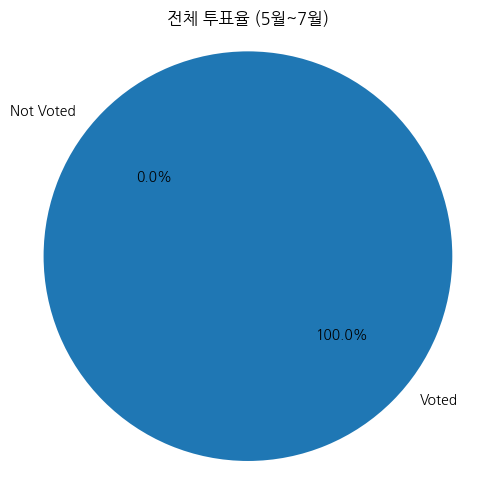

In [25]:
import matplotlib.pyplot as plt

labels = ['Voted', 'Not Voted']
sizes = [voted, total - voted]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('전체 투표율 (5월~7월)')
plt.axis('equal')
plt.tight_layout()
plt.show()


#### 질문 상태에 따른 투표율

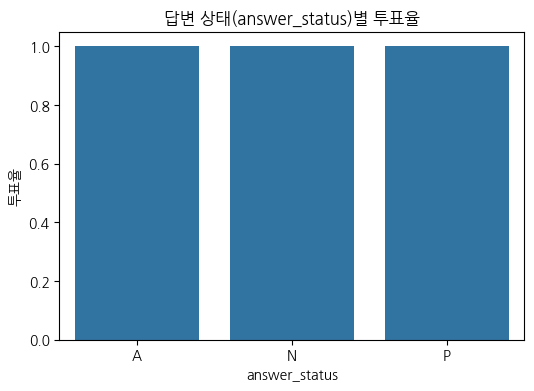

In [26]:
# answer_status 기준
vote_rate_answer = vote_5to7.groupby('answer_status')['is_voted'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=vote_rate_answer, x='answer_status', y='is_voted')
plt.ylabel('투표율')
plt.title('답변 상태(answer_status)별 투표율')
plt.show()

#### 질문별 투표율 (상위/하위 5개)

In [28]:
question_vote_rate = vote_5to7.groupby(['question_id', 'question_text'])['is_voted'].mean().reset_index()

# 상위 5개
top_q = question_vote_rate.sort_values(by='is_voted', ascending=False).head(5)

# 하위 5개
bottom_q = question_vote_rate.sort_values(by='is_voted', ascending=True).head(5)

display(top_q)
display(bottom_q)


,question_id,question_text,is_voted
0,99,가장 신비한 매력이 있는 사람은?,1.0
3066,3175,모든 순간이 화보인 사람은?,1.0
3072,3181,같이 도서관 가고 싶은 사람은?,1.0
3071,3180,태권도복이 잘 어울릴 것 같은 친구는?,1.0
3070,3179,모기를 가장 잘 물릴 것 같은 사람은?,1.0


,question_id,question_text,is_voted
0,99,가장 신비한 매력이 있는 사람은?,1.0
3059,3168,얼굴 바꾸고 싶은 사람,1.0
3060,3169,가장 창의적인 사람,1.0
3061,3170,자연미가 넘치는 사람,1.0
3062,3171,항상 신경쓰이는 사람,1.0


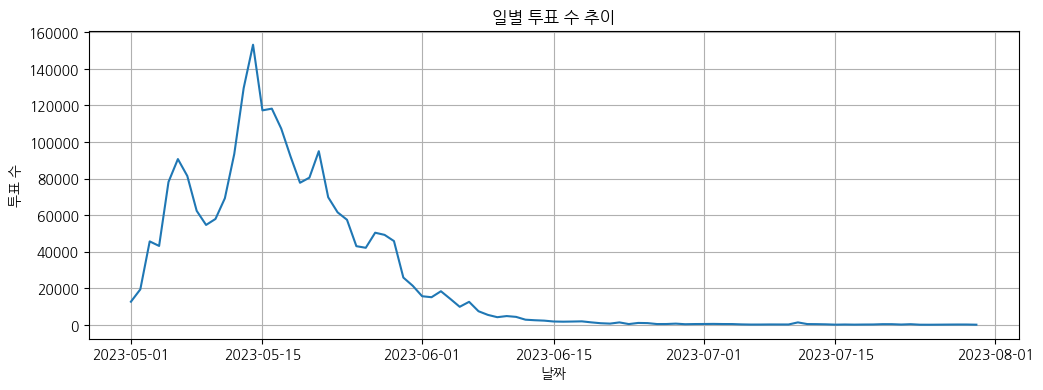

In [31]:
vote_daily = vote_5to7.groupby(vote_5to7['created_at'].dt.date)['is_voted'].sum()

# 시각화
plt.figure(figsize=(12,4))
vote_daily.plot()
plt.title('일별 투표 수 추이')
plt.xlabel('날짜')
plt.ylabel('투표 수')
plt.grid(True)
plt.show()


#### 특정 질문이 유독 자주 등장하는가? (이벤트 or 바이럴 가능성)

In [32]:
q_freq = vote_5to7['question_id'].value_counts().head(10)
q_info = vote_5to7[['question_id', 'question_text']].drop_duplicates()
top_qs = q_info[q_info['question_id'].isin(q_freq.index)]

display(pd.merge(top_qs, q_freq.rename('등장횟수'), left_on='question_id', right_index=True))


,question_id,question_text,등장횟수
31968,170,처음 보는 사람과 가장 빨리 친해질 것 같은 사람은?,3385
31980,309,흰티에 청바지가 잘 어울릴것 같은 사람은?,3344
32010,211,앞으로의 인생을 가장 재미있게 살것 같은 사람은?,3389
32032,189,자신감이 제일 높을거 같은 사람은?,3324
32062,102,여기서 제일 특이한 친구는?,3397
32218,186,vote,3402
32327,310,반려동물과 가장 잘 지낼거 같은 사람은?,3377
32332,152,숨겨진 댄싱 머신이라고 생각하는 사람은?,3350
32401,169,축제에서 공연을 제일 잘 할거 같은 사람은?,3403
48750,487,독특한 매력이 있는 사람은?,3366


/tmp/ipykernel_1831049/1865111794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vote_5to7['delta_sign'] = vote_5to7['delta_point'].apply(


delta_sign
Gain    0.953272
Loss    0.046726
Zero    0.000002
Name: proportion, dtype: float64


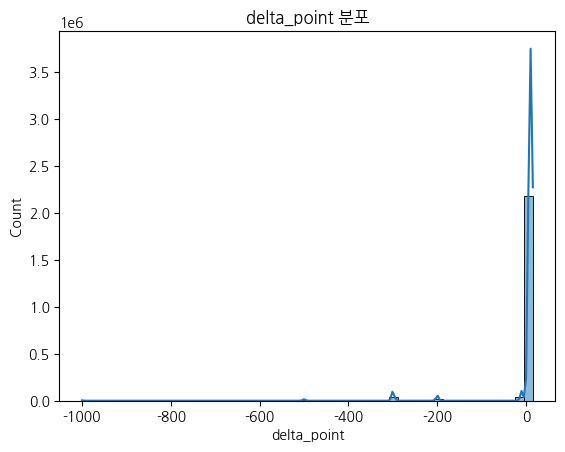

In [33]:
vote_5to7['delta_sign'] = vote_5to7['delta_point'].apply(
    lambda x: 'Gain' if x > 0 else 'Loss' if x < 0 else 'Zero'
)
print(vote_5to7['delta_sign'].value_counts(normalize=True))  # 비율 출력

# 시각화
sns.histplot(vote_5to7['delta_point'], bins=50, kde=True)
plt.title('delta_point 분포')
plt.show()


#### 특정 시간대(예: 새벽)에만 투표하는 유저 존재 여부

In [34]:
vote_5to7['hour'] = vote_5to7['created_at'].dt.hour
user_hour = vote_5to7.groupby(['user_id', 'hour']).size().reset_index(name='vote_count')

# 전체 대비 특정 시간대 집중도 높은 유저 추출
total_vote_per_user = user_hour.groupby('user_id')['vote_count'].sum().reset_index(name='total')
user_hour = user_hour.merge(total_vote_per_user, on='user_id')
user_hour['rate'] = user_hour['vote_count'] / user_hour['total']

# 예: 특정 유저가 전체 투표의 90% 이상을 새벽 0~4시에 했다면?
suspicious = user_hour[(user_hour['hour'].between(0,4)) & (user_hour['rate'] > 0.9)]
print("의심 유저 수:", suspicious['user_id'].nunique())
display(suspicious.head())


의심 유저 수: 19


/tmp/ipykernel_1831049/1889588182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vote_5to7['hour'] = vote_5to7['created_at'].dt.hour


,user_id,hour,vote_count,total,rate
4794,863154,4,4,4,1.0
6936,873436,0,10,10,1.0
7542,874052,4,4,4,1.0
13793,881024,4,14,14,1.0
17541,886062,3,13,13,1.0


In [35]:
# 1. suspicious 유저 목록
sus_users = suspicious['user_id'].unique()

# 2. 이 유저들의 포인트 합계
sus_points = vote_5to7[vote_5to7['user_id'].isin(sus_users)].groupby('user_id')['delta_point'].sum()
print(sus_points.describe())

# 3. 이 유저들이 참여한 질문
sus_q = vote_5to7[vote_5to7['user_id'].isin(sus_users)]['question_id'].value_counts().head()
print("상위 질문:", sus_q)

# 4. 리텐션 분석용: 최초~최종 활동일 차이
ret = vote_5to7[vote_5to7['user_id'].isin(sus_users)].groupby('user_id')['created_at'].agg(['min', 'max'])
ret['retention_days'] = (ret['max'] - ret['min']).dt.days
print(ret['retention_days'].describe())


count     19.000000
mean      74.157895
std       79.822207
min     -178.000000
25%       36.000000
50%       83.000000
75%      127.000000
max      172.000000
Name: delta_point, dtype: float64
상위 질문: question_id
502    4
471    4
181    3
217    3
554    3
Name: count, dtype: int64
count    19.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: retention_days, dtype: float64


19명의 유저는 다음과 같은 비정상적 특성을 보임
- 새벽 시간대에만 활동
- 단 하루만 활동하고 사라짐
- 소수 질문에 집중된 투표
- 포인트만 얻고 빠지는 행위
                
→ 이로 미루어 이벤트 참여를 위한 다계정/스팸 가능성이 높고,                    
→ 서비스 품질과 지표 신뢰도에 왜곡 영향을 줄 수 있다.             

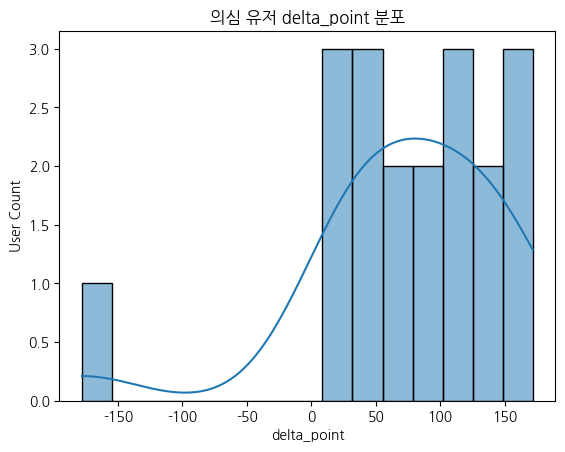

In [36]:

# suspicious 유저의 delta_point 분포
sns.histplot(sus_points, bins=15, kde=True)
plt.title("의심 유저 delta_point 분포")
plt.xlabel("delta_point")
plt.ylabel("User Count")
plt.show()